## <b>Problem statement:</b> 
### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Taking necessary actions to read the data:

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras.regularizers as regularizers

This work uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Updating the paths of the train and test dataset:
data_dir_train = pathlib.Path("/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    
    seed=123,
    validation_split=0.2,
    subset="training",
    
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    
    seed=123,
    validation_split=0.2,
    subset="validation",
    
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and storing them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Creating code to visualize one instance of all the nine classes present in the dataset:

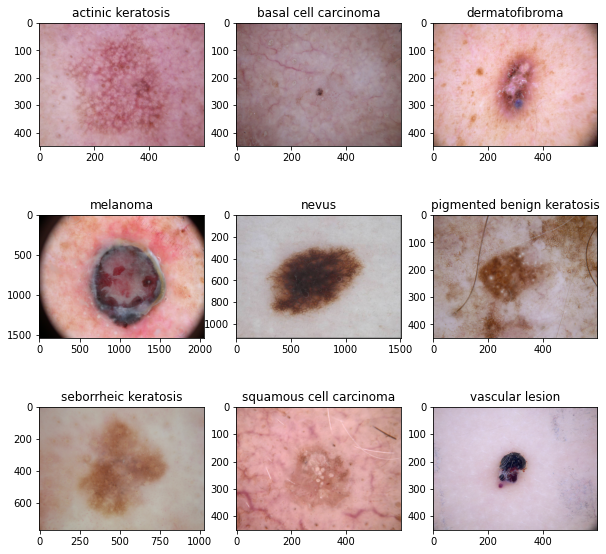

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)  
  plt.title(class_names[i])
  plt.imshow(plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1])))


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### <b>1. Creating the first model:</b>
#### Creating an initial CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it has been standardized to to be in the range between `[0, 1]`

In [12]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model
#### Compiling the model using an appropirate optimiser and loss function for model training: 

In [13]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# Viewing the summary of all layers:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        5

### Training the model:

In [15]:
epochs = 20
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 529s 2s/step - loss: 2.1850 - accuracy: 0.2126 - val_loss: 2.0602 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 1.9974 - accuracy: 0.2467 - val_loss: 1.9188 - val_accuracy: 0.2908
Epoch 3/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8764 - accuracy: 0.3019 - val_loss: 1.9868 - val_accuracy: 0.2796
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 1.8776 - accuracy: 0.3080 - val_loss: 1.7645 - val_accuracy: 0.3557
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 1.7026 - accuracy: 0.3756 - val_loss: 1.6311 - val_accuracy: 0.4295
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5978 - accuracy: 0.4269 - val_loss: 1.7625 - val_accuracy: 0.3669
Epoch 7/20
56/56 [==============================] - 4s 74ms/step - loss: 1.5478 - accuracy: 0.4537 - val_loss: 1.6409 - val_accuracy: 0.4116
Epoch 8/20
56

### Visualizing training results

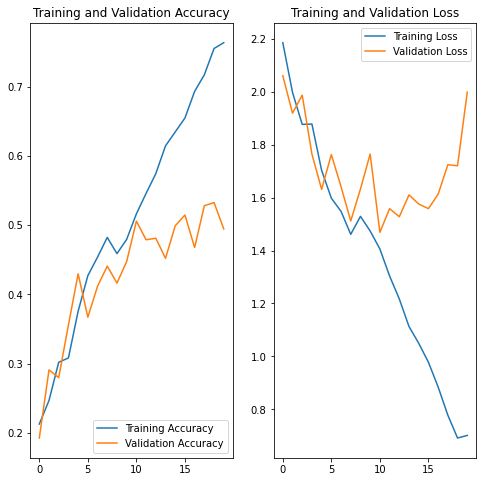

In [16]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings here:
#### <li>The training data accuracy is high, but the validation data accuracy of the model is low, indicating <b>overfitting<b>.</li>
#### <li>Overfitting can be minimized using one or more of the below techniques:</li>
##### <li>Using one or more of the image data augmentation layers (e.g. RandomFlip,RandomRotation,RandomZoom etc.).</li>
##### <li>Using a regularization layer (e.g. Dropout layer).</li>
##### <li>Batch normalization.</li>

### To handle the issue of overfitting, we will use an augumentation strategy, where augmentation layers are added, with random horizontal and vertical flipping and random rotation of the images used for training and validation:

In [ ]:
 

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.5),
])


### Visualizing our augmentation strategy and how it works, by checking for one instance per class of the images present in the training data set:


In [ ]:

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for idx in range(len(class_names)):
        ax = plt.subplot(3, 3, idx + 1)
        plt.imshow(data_augmentation(images)[idx].numpy().astype("uint8"))
        plt.title(class_names[labels[idx]])
        plt.axis("off")
plt.show()

### <b>2. Creating the second model:


In [20]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model:

In [21]:

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Training the model:

In [22]:

history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 6s 82ms/step - loss: 2.0416 - accuracy: 0.2160 - val_loss: 1.9511 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8986 - accuracy: 0.3231 - val_loss: 1.6989 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 4s 78ms/step - loss: 1.8367 - accuracy: 0.3304 - val_loss: 1.7031 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7702 - accuracy: 0.3398 - val_loss: 1.6882 - val_accuracy: 0.3893
Epoch 5/20
56/56 [==============================] - 4s 78ms/step - loss: 1.5989 - accuracy: 0.4224 - val_loss: 1.7847 - val_accuracy: 0.3714
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5393 - accuracy: 0.4693 - val_loss: 1.5888 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5230 - accuracy: 0.4604 - val_loss: 1.4816 - val_accuracy: 0.4698
Epoch 8/20
56/56 [======

### Visualizing the results

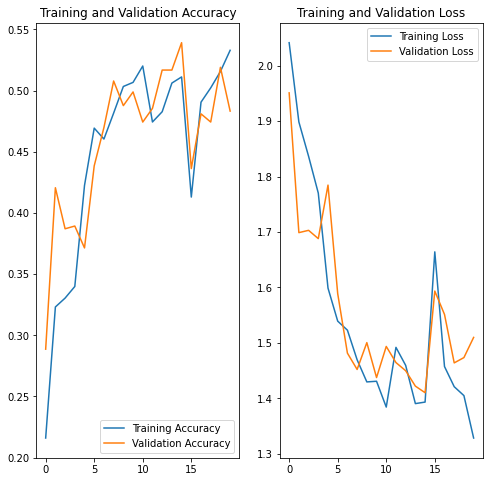

In [23]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
#### <li>Overfitting is no longer present.</li>
#### <li>However, both the training and test data accuracies are similar, but the accuracies are poor and they tend to underfit.</li>
#### <li>The underfitting can be handled by one or more of the below possible techniques:</li>
##### <li>Adding more layers to the model.</li>
##### <li>Handling the class imbalance issue in the data, if any.</li>
##### <li>Fine-tuning or removing any regularization parameters if required.</li>

### <b>3. Analyzing the distribution of classes in the training dataset:</b>
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
image_list=[]
class_list=[]
for Class in class_names:
  for image in data_dir_train.glob(Class+'*/*.jpg'):
    image_list.append(str(image))
    class_list.append(Class)
df_dict_temp=dict(zip(image_list,class_list))
df_image_class=pd.DataFrame(df_dict_temp.items(),columns=['Path','Class'])
    

In [ ]:
df_image_class.head()

In [26]:
df_image_class.Class.value_counts().sum()

2239

In [27]:
df_image_class.Class.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Class, dtype: int64

### Findings: 
#### <li>The classes 'dermatofibroma' and 'seborrheic keratosis' have the least number of samples.</li>
#### <li>The 4 classes 'pigmented benign keratosis','melanoma','basal cell carcinoma' and 'nevus' account for approximately 73% of all the samples.</li>
#### <li>Hence there is a need to address this class imbalance.</li>


### Rectifying the class imbalance:
#### Using the python package `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object. In our case, we do both left/right rotation and flipping of images, to make the dataset more diverse.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_random(0.5)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [30]:
data_dir_train = pathlib.Path("/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of the augmented data of new images which will be added to the original training data, before building a newer model:

In [31]:
image_list_new=[]
class_list_new=[]

for Class in class_names:
  for image in data_dir_train.glob(Class+'*/output/*.jpg'):
    image_list_new.append(str(image))
    class_list_new.append(Class)
df_dict_temp_new=dict(zip(image_list_new,class_list_new))
df_image_class_new=pd.DataFrame(df_dict_temp_new.items(),columns=['Path','Class'])
df_image_class_new.append(df_image_class)
df_image_class_new.Class.value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Class, dtype: int64

### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve the training process.

### <b> 4. Creating the 3rd model on the data enhanced using Augmentor:
#### NOTE: Here, the train-validation split has been modified to the ratio 60% training data and 40% validation data (60:40), to give the model more data to be validated upon, and dropouts have also been added.

In [32]:
batch_size = 32
img_height = 180
img_width = 180

### Creating a training dataset:

In [33]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    
    seed=123,
    validation_split=0.4,
    subset="training",
    
)

Found 6739 files belonging to 9 classes.
Using 4044 files for training.


### Creating a validation dataset:

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    
    seed=123,
    validation_split=0.4,
    subset="validation",
    
)

Found 6739 files belonging to 9 classes.
Using 2695 files for validation.


### Creating, compiling and training our 3rd model (with some normalization in the form of droputs included):

In [38]:
model3 = Sequential([
  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),
  layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.5),
  layers.Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.75),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [39]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [40]:
epochs = 30
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
127/127 [==============================] - 40s 303ms/step - loss: 2.2009 - accuracy: 0.1444 - val_loss: 2.1880 - val_accuracy: 0.1232
Epoch 2/30
127/127 [==============================] - 39s 295ms/step - loss: 2.1759 - accuracy: 0.1456 - val_loss: 2.1838 - val_accuracy: 0.1570
Epoch 3/30
127/127 [==============================] - 38s 294ms/step - loss: 1.9503 - accuracy: 0.2436 - val_loss: 1.7518 - val_accuracy: 0.3276
Epoch 4/30
127/127 [==============================] - 38s 293ms/step - loss: 1.7836 - accuracy: 0.3301 - val_loss: 1.7211 - val_accuracy: 0.3581
Epoch 5/30
127/127 [==============================] - 38s 294ms/step - loss: 1.6245 - accuracy: 0.3764 - val_loss: 1.6786 - val_accuracy: 0.3562
Epoch 6/30
127/127 [==============================] - 39s 295ms/step - loss: 1.5685 - accuracy: 0.4021 - val_loss: 1.4935 - val_accuracy: 0.4315
Epoch 7/30
127/127 [==============================] - 38s 292ms/step - loss: 1.5280 - accuracy: 0.4073 - val_loss: 1.4879 - val_ac

#### Visualizing the model results:

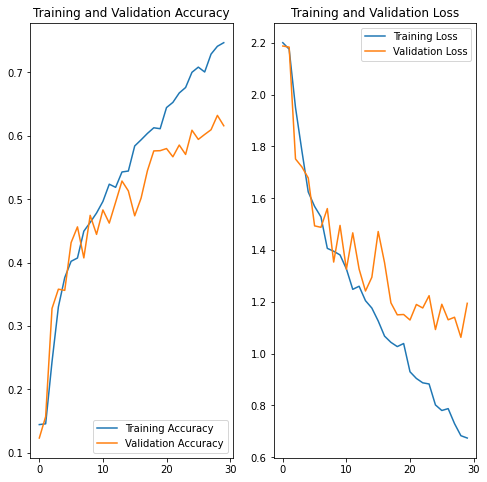

In [41]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
#### <li>The issue of underfitting from the 2nd model was fixed.</li>
#### <li>Throughout the training process, the model's performance was stable, and its accuracy increased in an incremental manner, for both the validation and the training data.</li>
#### <li>There is a slightly noticeable difference between the final accuracies of the model on both the (partial overfitting). This can be addressed by building a newer models with one or more of the following:
##### <ol> 1. more number of samples added to the data, using the Augmentor library.
##### <ol> 2. more number of epochs, say 30 or 40 epochs.
##### <ol> 3. some more layers in the model to address overfitting : e.g. dropouts etc.
##### <ol> 4. using different combinations of activation and loss functions.

